In [1]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 

No pytransport functionality
No pytransport functionality


# OUTPUT TEST 

In [ ]:
loaded_df = pd.read_hdf(("./Outputdata/test_particles_B2V.h5"), key='particles') #test_particles_B2V

drop_list = ['chi', 'charge_ratio', 'pdg_id', 'rvv', 'rpp', '_rng_s1', '_rng_s2', '_rng_s3', '_rng_s4', 'weight', 'ptau', 'q0', 'beta0', 'mass0']
float_variables = ['s', 'zeta', 'x', 'px', 'y', 'py', 'delta', 'gamma0', 'p0c']
int_variables = ['at_turn', 'particle_id', 'at_element', 'start_tracking_at_element', 'state', 'parent_particle_id']
loaded_df.drop(drop_list, axis=1, inplace=True)



In [ ]:
loaded_df

In [ ]:
print(loaded_df.dtypes)

loaded_df[float_variables] = loaded_df[float_variables].astype('float32')
loaded_df[int_variables] = loaded_df[int_variables].astype('int32')

print(loaded_df.dtypes)

In [ ]:
loaded_df

In [ ]:
file = ("./Outputdata/t")
with open(file, 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
loaded_dict

In [ ]:
new_loaded_df = pd.read_hdf(("./Outputdata/new_test_particles_B2V.h5"), key='particles') #test_particles_B2V

In [ ]:
new_loaded_df.dtypes

In [ ]:
import h5py

def save_dict_to_hdf(dictionary, file_path, group_name='data', compression='gzip'):
    with h5py.File(file_path, 'w') as hdf_file:
        # Create a group in the HDF file
        group = hdf_file.create_group(group_name)
        
        # Save each key-value pair in the dictionary as a dataset in the group
        for key, value in dictionary.items():
            # Apply compression to the dataset
            group.create_dataset(str(key), data=value, compression=compression)

# Example dictionary
my_dict = {'key1': [1, 2, 3], 'key2': 'value2', 'key3': 3.14}

# Specify the file path where you want to save the compressed HDF file
file_path = 'my_dict_compressed.h5'

# Save the dictionary to a compressed HDF file (using gzip compression in this case)
save_dict_to_hdf(my_dict, file_path)

print(f'Dictionary saved to {file_path}')

In [ ]:
import pandas as pd

# Example DataFrame
data = {'Name': ['Alice', 'Bob', 'Charlie'],
        'Age': [25, 30, 35],
        'City': ['New York', 'San Francisco', 'Los Angeles']}

df = pd.DataFrame(data)

# Specify the file path where you want to save the compressed HDF5 file
file_path = 'my_dataframe_compressed.h5'

# Save the DataFrame to a compressed HDF5 file with gzip compression
df.to_hdf(file_path, key='data', mode='w', complevel=9, complib='zlib')

print(f'DataFrame saved to {file_path}')

In [ ]:
def _save_particles_hdf(particles=None, lossmap_data=None, filename='part'):
    if not filename.endswith('.hdf'):
        filename += '.hdf'

    fpath = Path(filename)
    # Remove a potential old file as the file is open in append mode
    if fpath.exists():
        fpath.unlink()

    if particles is not None:
        df = particles.to_pandas(compact=True)
        df.to_hdf(fpath, key='particles', format='table', mode='a',
                  complevel=9, complib='blosc')

    if lossmap_data is not None:
        for key, lm_df in lossmap_data.items():
            lm_df.to_hdf(fpath, key=key, mode='a', format='table',
                         complevel=9, complib='blosc')

# LOAD LINE

In [2]:
def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    print('vmabc.4l2.b.b2_aper' in aperture_offsets.keys())
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers



In [1]:
    config_file ='config_sim.yaml'

    with open(config_file, 'r') as stream:
        config_dict = yaml.safe_load(stream)



    run_dict = config_dict['run']
    file_dict = config_dict['input_files']


    context = xo.ContextCpu(omp_num_threads='auto')

    # On a modern CPU, we get ~5000 particle*turns/s
    # So this script should take around half an hour
    beam          = run_dict['beam']
    plane         = run_dict['plane']

    num_turns     = run_dict['turns']
    num_particles = run_dict['nparticles']
    engine        = run_dict['engine']

    TTCS_align_angle_step = run_dict['TTCS_align_angle_step']

    #--------------------------------------------------
    num_turns     = 100 #run_dict['turns']
    num_particles = 20 #run_dict['nparticles']
    mode = 'monitors' #run_dict['mode']
    #--------------------------------------------------

    path_out = Path.cwd() / 'Outputdata'

    if not path_out.exists():
        os.makedirs(path_out)


    # Load from json
    line = xt.Line.from_json(file_dict[f'line_b{beam}'])

    end_s = line.get_length()


    TCCS_loc = end_s - 6773.7 #6775
    TCCP_loc = end_s - 6653.3 #6655
    TARGET_loc = end_s - (6653.3 + 0.07/2 +0.005/2)


    TCCS_name = 'tccs.5r3.b2'
    TCCP_name = 'tccp.4l3.b2'
    TARGET_name = 'target.4l3.b2'
    TCLA_name = 'tcla.a5l3.b2'


    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name='tccs.5r3.b2')
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccs.5r3.b2_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name='tccp.4l3.b2')
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccp.4l3.b2_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name='target.4l3.b2')
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='target.4l3.b2_aper')


    TCCS_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TARGET_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    line.insert_element(index=TCCS_name, element=TCCS_monitor, name='TCCS_monitor')
    line.insert_element(index=TARGET_name, element=TARGET_monitor, name='TARGET_monitor')

    #line.cycle(name_first_element='ip3', inplace=True)

    bad_aper = find_bad_offset_apertures(line)
    print('Bad apertures : ', bad_aper)
    print('Replace bad apertures with Marker')
    for name in bad_aper.keys():
        line.element_dict[name] = xt.Marker()
        print(name, line.get_s_position(name), line.element_dict[name])



    # Aperture model check
    print('\nAperture model check on imported model:')
    df_imported = line.check_aperture()
    assert not np.any(df_imported.has_aperture_problem)




    # Initialise collmanager
    coll_manager = xc.CollimatorManager.from_yaml(file_dict['collimators'], line=line, beam=beam, _context=context, ignore_crystals=False)

    #print(coll_manager.collimator_names)

    # Install collimators into line
    if engine == 'everest':
        coll_names = coll_manager.collimator_names

        if mode == 'cry_black_absorbers':
            black_absorbers = ['target.4l3.b2', 'tccs.5r3.b2']
        elif mode == 'angular_scan': 
            black_absorbers = ['target.4l3.b2',]
        else: 
            black_absorbers = []

        everest_colls = [name for name in coll_names if name not in black_absorbers]
        coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
        coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)


    else:
        raise ValueError(f"Unknown scattering engine {engine}!")


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

        
    # Build the tracker
    coll_manager.build_tracker()


    # Set the collimator openings based on the colldb,
    # or manually override with the option gaps={collname: gap}
    coll_manager.set_openings()


    if mode == 'angular_scan':
        print("\nTTCS aligned to beam: ", line[TTCS_name].align_angle)
        #line[TTCS_name].align_angle = TTCS_align_angle_step

        line[TTCS_name].align_angle = line[TTCS_name].align_angle + TTCS_align_angle_step
        print("TTCS align angle incremented by step: ", line[TTCS_name].align_angle)


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    #assert not np.any(df_with_coll.has_aperture_problem)



NameError: name 'yaml' is not defined

### MULTITURN ANALYSIS

In [6]:
    # Generate initial pencil distribution on horizontal collimator
    tcp  = f"tcp.{'c' if plane=='H' else 'd'}6{'l' if beam=='1' else 'r'}7.b{beam}"
    part = coll_manager.generate_pencil_on_collimator(tcp, num_particles=num_particles)


    # Optimise the line
    #line.optimize_for_tracking()
    idx = line.element_names.index(tcp)
    part.at_element = idx
    part.start_tracking_at_element = idx


    # Track
    coll_manager.enable_scattering()
    line.track(part, num_turns=num_turns, time=True)
    coll_manager.disable_scattering()
    print(f"Done tracking in {line.time_last_track:.1f}s.")


    # Save lossmap to json, which can be loaded, combined (for more statistics),
    # and plotted with the 'lossmaps' package
    _ = coll_manager.lossmap(part, file=Path(path_out,f'lossmap_B{beam}{plane}.json'))


    # Save a summary of the collimator losses to a text file
    summary = coll_manager.summary(part) #, file=Path(path_out,f'coll_summary_B{beam}{plane}.out')
    print(summary)

    if mode == 'cry_black_absorbers':
        df_part = part.to_pandas()
        df_part.to_hdf(Path(path_out,f'particles_B{beam}{plane}.h5'), key='df', mode='w') 


    if mode == 'monitors':
        TCCS_monitor_dict = TCCS_monitor.to_dict()
        TARGET_monitor_dict = TARGET_monitor.to_dict()
        with open(Path(path_out,f'TCCS_monitor_B{beam}{plane}.pkl'), 'wb') as f:
            pickle.dump(TCCS_monitor_dict, f)
        with open(Path(path_out,f'TARGET_monitor_B{beam}{plane}.pkl'), 'wb') as f:
            pickle.dump(TARGET_monitor_dict, f)
        

Collimator tcp.d6r7.b2 is diverging.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking in 1.2s.
        collname  nabs  length             s               type
10   tcp.d6r7.b2    10     0.6  20199.140374  EverestCollimator
13  tcsg.a6r7.b2     2     1.0  20155.645876  EverestCollimator
15  tcsg.b5r7.b2     2     1.0  20096.418376  EverestCollimator
16  tcsg.a5r7.b2     2     1.0  20092.418376  EverestCollimator


#### xarrays

In [8]:

def plot_distributions_at_turn(arr_path, turn):
    
    arr =  xr.open_dataarray(arr_path)
    alive_arr = arr.where(arr.loc[:, 'state', turn] > 0, drop = True)[:,:,turn]

    fig1 = plt.figure( figsize=(24, 5))
    ax1 = fig1.add_subplot(1,3,1)
    ax1.hist(alive_arr.loc[:, 'x'], bins=100)
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel("")
    #ax1.set_yscale("log")
    ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])


    ax2 = fig1.add_subplot(1,3,2)
    ax2.hist(alive_arr.loc[:, 'y'], bins=100) 
    ax2.set_xlabel('y [mm]')
    ax2.set_ylabel('')
    #ax2.set_yscale("log")
    ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax2.set_title(f'Total particles: {alive_arr.shape[0]}')

    ax3 = fig1.add_subplot(1,3,3)
    h = ax3.hist2d(alive_arr.loc[:, 'x'], alive_arr.loc[:, 'y'], bins=100, norm=matplotlib.colors.LogNorm())#vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
    ax3.set_xlabel(r'x [mm]')
    #ax3.set_ylim(0,0.008)
    ax3.set_ylabel(r'y [mm]')
    ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e3:.{1}f}" for y in plt.yticks()[0]])

    axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
    fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
    ax3.grid(linestyle=':')

    

    


    """ax3_tw = ax3.twinx()
    ticks = np.arange(1, max(ax3.get_yticks())/sigma+1, 2.0)
    ax3_tw.set_yticks(ticks)
    ax3_tw.set_ylabel(r' n $\sigma$')
    ax3_tw.set_yticklabels([f"{x /sigma :.{0}f}"  for x in ticks])
    ax3_tw.axhline(5, color = 'r', linestyle = '--')
    ax3_tw.text( max(ax3.get_xticks())-1.5e-3, 4, r'TCP $\sigma$')"""
    

    fig1.suptitle('plot')
    plt.show()


    return fig1, [ax1,ax2,ax3]

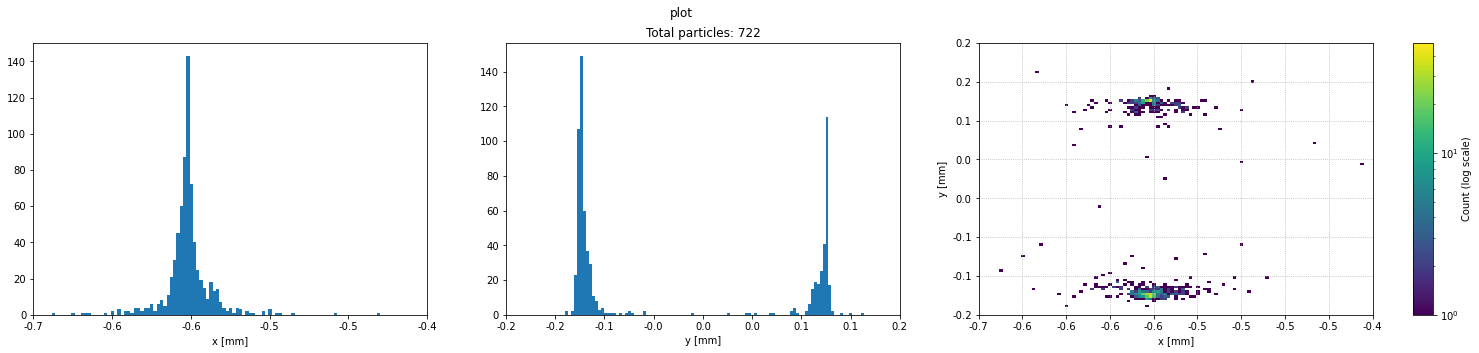

In [9]:
fig, ax_list = plot_distributions_at_turn("./Outputdata/part_200turns_5000.nc", 120)

In [263]:
part_array.to_netcdf("./Outputdata/part_200turns_5000.nc")

In [58]:
part_array =  xr.open_dataarray("./Outputdata/part_200turns_5000.nc")

## Particle monitor

In [4]:


num_particles = 50
particles = xp.generate_matched_gaussian_bunch(line=line,
                                               num_particles=num_particles,
                                               nemitt_x=2.5e-6,
                                               nemitt_y=2.5e-6,
                                               sigma_z=9e-2)

num_turns = 30
line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=True # <--
             )
# line.record_last_track contains the measured data. For example,
# line.record_last_track.x contains the x coordinate for all particles
# and all turns, e.g. line.record_last_track.x[3, 5] for the particle
# having particle_id = 3 and for the turn number 5.

# Monitor objects can be dumped to a dictionary and loaded back
mon = line.record_last_track
dct = mon.to_dict()
mon2 = xt.ParticlesMonitor.from_dict(dct)

*** Maximum RMS bunch length 0.11789515101464533m.
... distance to target bunch length: -9.0000e-02
... distance to target bunch length: 2.4638e-02
... distance to target bunch length: 2.2508e-02
... distance to target bunch length: 4.1016e-03
... distance to target bunch length: -8.2454e-03
... distance to target bunch length: 6.8134e-04
... distance to target bunch length: -1.5958e-05
... distance to target bunch length: 2.5080e-07
... distance to target bunch length: -3.9266e-08
--> Bunch length: 0.08999996073381338
--> Emittance: 2.519533584726556


In [6]:
dct

{'__class__': 'ParticlesMonitor',
 'start_at_turn': 0,
 'stop_at_turn': 30,
 'part_id_start': 0,
 'part_id_end': 50,
 'ebe_mode': 0,
 'n_records': 1500,
 'n_repetitions': 1,
 'repetition_period': -1,
 'flag_auto_to_numpy': 1,
 'data': {'start_tracking_at_element': 0,
  'q0': 0.0,
  'mass0': 0.0,
  's': array([0., 0., 0., ..., 0., 0., 0.]),
  'zeta': array([-0.12061588, -0.11986674, -0.11910322, ...,  0.08688751,
          0.08642452,  0.08595109]),
  'chi': array([1., 1., 1., ..., 1., 1., 1.]),
  'charge_ratio': array([1., 1., 1., ..., 1., 1., 1.]),
  'weight': array([1., 1., 1., ..., 1., 1., 1.]),
  'pdg_id': array([0, 0, 0, ..., 0, 0, 0]),
  'particle_id': array([ 0,  0,  0, ..., 49, 49, 49]),
  'at_element': array([0, 0, 0, ..., 0, 0, 0]),
  'at_turn': array([ 0,  1,  2, ..., 27, 28, 29]),
  'state': array([1, 1, 1, ..., 1, 1, 1]),
  'parent_particle_id': array([ 0,  0,  0, ..., 49, 49, 49]),
  '_rng_s1': array([1782793756, 1782793756, 1782793756, ..., 1954694666, 1954694666,
      

 allow_backtrack at_element    at_turn   auto_to_numpy   behaves_like_drift   beta0   charge_ratio   chi   compile_kernels   context   copy   data   delta   ebe_mode extra_sources flag_auto_to_numpy from_dict gamma0 get_backtrack_element has_backtrack init_pipeline iscollective isthick move n_records n_repetitions p0c parent_particle_id part_id_end part_id_start particle_id pdg_id ptau px py pzeta repetition_period rpp rvv s skip_in_loss_location_refinement start_at_turn state stop_at_turn to_dict track weight x xoinitialize y zeta

In [8]:
mon.to_dict()['data'].keys()

dict_keys(['start_tracking_at_element', 'q0', 'mass0', 's', 'zeta', 'chi', 'charge_ratio', 'weight', 'pdg_id', 'particle_id', 'at_element', 'at_turn', 'state', 'parent_particle_id', '_rng_s1', '_rng_s2', '_rng_s3', '_rng_s4', 'x', 'y', 'px', 'py', 'delta', 'ptau', 'rvv', 'rpp', 'p0c', 'beta0', 'gamma0'])

In [26]:
line.discard_tracker()

In [27]:
num_particles = 50
monitor_ip5 = xt.ParticlesMonitor(start_at_turn=5, stop_at_turn=15,
                                    num_particles=num_particles)
monitor_ip8 = xt.ParticlesMonitor(start_at_turn=5, stop_at_turn=15,
                                    num_particles=num_particles)
line.insert_element(index='ip5', element=monitor_ip5, name='mymon5')
line.insert_element(index='ip8', element=monitor_ip8, name='mymon8')

line.build_tracker()

particles = xp.generate_matched_gaussian_bunch(line=line,
                                               num_particles=num_particles,
                                               nemitt_x=2.5e-6,
                                               nemitt_y=2.5e-6,
                                               sigma_z=9e-2)

num_turns = 30
monitor = xt.ParticlesMonitor(_context=context,
                              start_at_turn=5, stop_at_turn=15,
                              num_particles=num_particles, auto_to_numpy = True)
line.track(particles, num_turns=num_turns)

# monitor_ip5 contains the data recorded in before the element 'ip5', while
# monitor_ip8 contains the data recorded in before the element 'ip8'
# The element index at which the recording is made can be inspected in
# monitor_ip5.at_element.

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.11789515101464533m.
... distance to target bunch length: -9.0000e-02
... distance to target bunch length: 2.4638e-02
... distance to target bunch length: 2.2508e-02
... distance to target bunch length: 4.1016e-03
... distance to target bunch length: -8.2454e-03
... distance to target bunch length: 6.8134e-04
... distance to target bunch length: -1.5958e-05
... distance to target bunch length: 2.5080e-07
... distance to target bunch length: -3.9266e-08
--> Bunch length: 0.08999996073381338
--> Emittance: 2.519533584726556


In [184]:
type(monitor)

xtrack.monitors.particles_monitor.ParticlesMonitor

In [57]:
monitor_ip5.at_element.shape

(50, 10)

In [53]:
line.get_s_position()[52904+1] == line.get_s_position()[52904] 

True

In [11]:
pd.DataFrame.from_dict(loaded_dict, orient='columns')

NameError: name 'loaded_dict' is not defined

In [ ]:
dictionary

{'start_tracking_at_element': 0,
 'q0': 0.0,
 'mass0': 0.0,
 's': array([13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255, 13329.2892255,
        13329.2892255, 13329.2892255, 13329.2892255

In [ ]:
dictionary['x'].shape

(500,)

In [23]:
dictionary = monitor_ip5.to_dict()

In [24]:

with open('Outputdata/prova_pickle3.pkl', 'wb') as f:
    pickle.dump(dictionary, f)
        
with open('Outputdata/prova_pickle3.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

#### Class

In [162]:
class TurnAnalysis():

    def __init__(self, beam = 2, plane = 'V'):

        self.beam = beam
        self.plane = plane
        self.nturns = None
        self.npart = None
        self.data_dict = None
        self.data = None
        self.type = None


    def load(self, pkl_file_path):

        if not hasattr(pkl_file_path, '__iter__') or isinstance(pkl_file_path, str):
            pkl_file_path = [pkl_file_path]

        data_dict = {'x': np.empty(0), 'y': np.empty(0), 'px': np.empty(0), 'py': np.empty(0), 'zeta': np.empty(0), 'delta': np.empty(0), 'state': np.empty(0), 'at_element': np.empty(0), }
        npart = 0

        fi = 1 

        for file in pkl_file_path:

            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            if fi:
                nturns = loaded_dict['stop_at_turn'] - loaded_dict['start_at_turn']
                fi = 0

            npart = npart + loaded_dict['part_id_end'] - loaded_dict['part_id_start']

            for key, value in data_dict.items():
                data_dict[key] = np.concatenate((value, np.array(loaded_dict['data'][key]))) 

        self.npart = npart
        self.nturns = nturns
        

        for key, value in data_dict.items():
                data_dict[key] = value.reshape(npart, nturns)

        self.data_dict = data_dict

        data_arrays = []
        for key, matrix in data_dict.items():
            data_arrays.append(xr.DataArray(matrix, dims=('id', 'turn'), name=key))

        data = xr.concat(data_arrays, dim='property')
        data = data.assign_coords(id = np.arange(npart), property = list(data_dict.keys()), turn = np.arange(nturns))
        
        self.data = data


    def plot_alive(self):
        alive_part = []
        for turn in range(self.nturns):
            alive_part.append(self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True).shape[1])

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(a.data.coords['turn'], alive_part)
        ax.set_xlabel('turn')
        ax.set_ylabel('Number of particles')



    def plot_distributions_at_turn(self, turn):
        alive_arr = self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True)[:,:,turn]

        fig1 = plt.figure( figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(alive_arr.loc['x', :], bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        #ax1.set_yscale("log")
        ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])


        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(alive_arr.loc['y',:], bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.set_ylabel('')
        #ax2.set_yscale("log")
        ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
        ax2.set_title(f'Total particles: {alive_arr.shape[1]}')

        ax3 = fig1.add_subplot(2,3,3)
        h = ax3.hist2d(alive_arr.loc['x', :], alive_arr.loc['y', :], bins=100, norm=matplotlib.colors.LogNorm())#vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax3.set_xlabel(r'x [mm]')
        #ax3.set_ylim(0,0.008)
        ax3.set_ylabel(r'y [mm]')
        ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
        ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e3:.{1}f}" for y in plt.yticks()[0]])

        axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax3.grid(linestyle=':')




        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(alive_arr.loc['px', :], bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")
        #ax12.set_yscale("log")
        ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])


        ax22 = fig1.add_subplot(2,3,5)
        ax22.hist(alive_arr.loc['py', :], bins=100) 
        ax22.set_xlabel(r'py [$\mu$rad]')
        ax22.set_ylabel('')
        #ax22.set_yscale("log")
        #ax22.axvline(py_central, color = 'red', linestyle = '-', alpha = 0.8)
        #ax22.axvline(py_central + critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
        #ax22.axvline(py_central - critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
        ax22.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
        #chann = len(cry_impact_parts[(cry_impact_parts.py > py_central - critical_angle) & (cry_impact_parts.py < py_central + critical_angle)])
        #ax22.set_title(f'N particle inside critical angle range: {chann}')

        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(alive_arr.loc['px', :], alive_arr.loc['py', :], bins=100, norm=matplotlib.colors.LogNorm())  #, range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
        ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e6:.{0}f}" for y in plt.yticks()[0]])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        #fig1.suptitle('plot')
        plt.show()




        #return fig1, [ax1,ax2,ax3]


    def plot_particle_history(self, property_name, part_id):

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(a.data.coords['turn'], self.data.loc[property_name, part_id])
        ax.set_xlabel('turn')
        ax.set_ylabel(property_name)


In [163]:
a = TurnAnalysis()
b = TurnAnalysis()

In [164]:
pickle_list = ['Outputdata/prova_pickle2.pkl' , 'Outputdata/prova_pickle3.pkl']

In [165]:
a.load(pickle_list)
b.load('Outputdata/prova_pickle2.pkl')

In [166]:
#mon2 = xt.ParticlesMonitor.from_dict(dct)
with open('Outputdata/prova_pickle2.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
mon2 = xt.ParticlesMonitor.from_dict(loaded_dict)

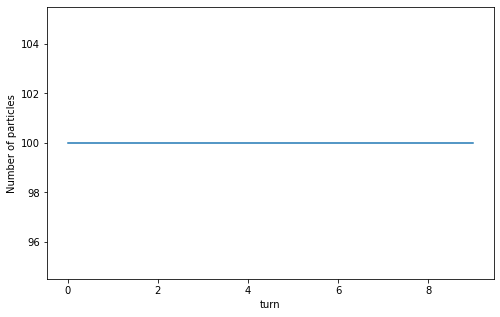

In [167]:
a.plot_alive()

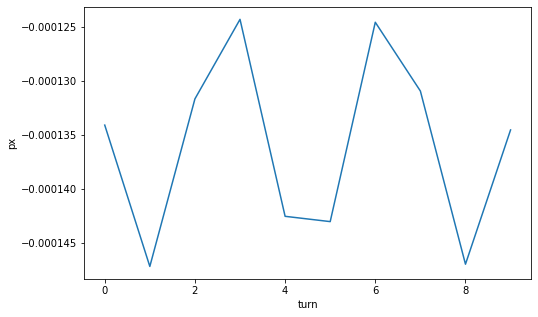

In [168]:
a.plot_particle_history('px', 1)

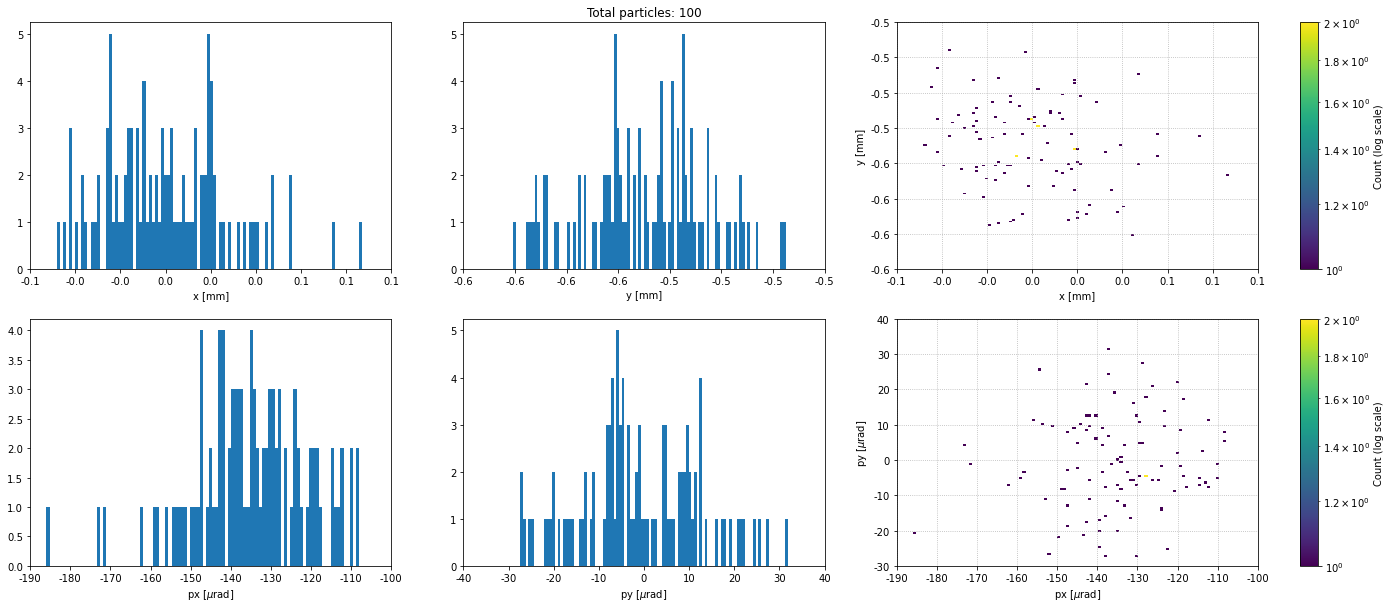

In [169]:
a.plot_distributions_at_turn(9)

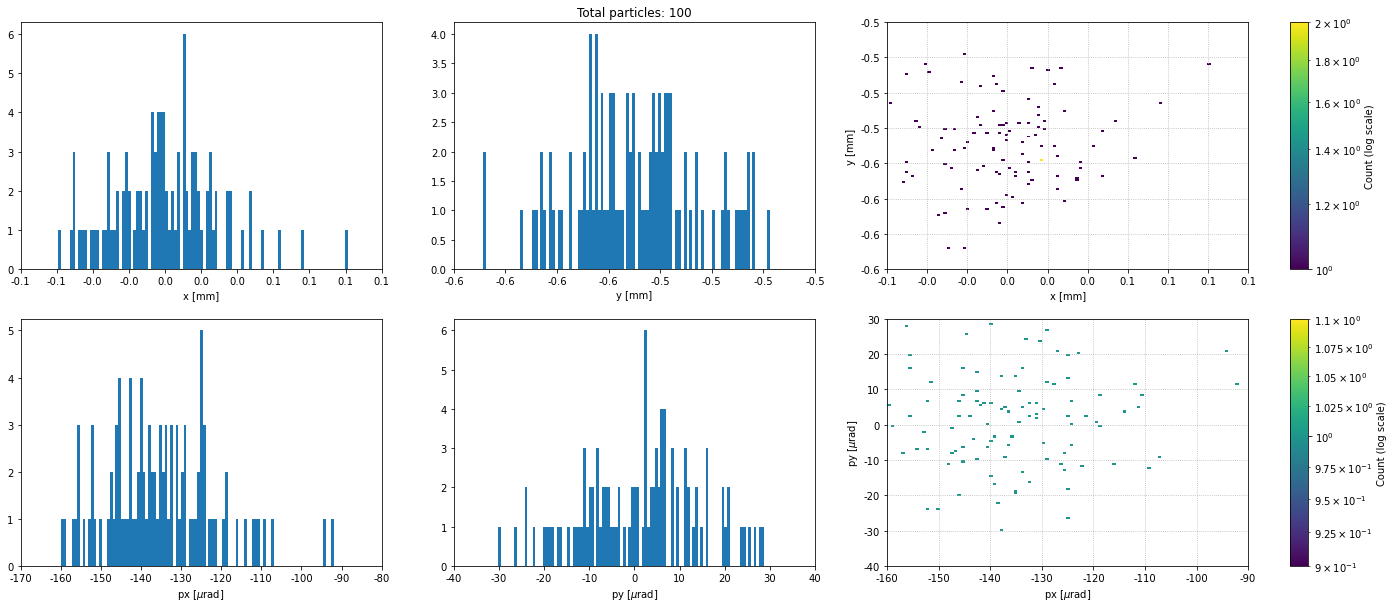

In [170]:
a.plot_distributions_at_turn(1)


In [91]:
#turns = loaded_dict_1['stop_at_turn'] - loaded_dict_1['start_at_turn']
parts = 

id_p = 6

idsss = np.arange(id_p, parts + id_p)
repeated_array = np.array([num for num in idsss for _ in range(turns)])
type(repeated_array)

numpy.ndarray

In [120]:
a.data.coords['turn']#loc['x', 0]

<xarray.DataArray 'turn' (turn: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
  * turn     (turn) int64 0 1 2 3 4 5 6 7 8 9

## impact distributions plots

In [ ]:
#df_new =  pd.read_hdf('/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_ABS_CRY1__20231113-1818/Job.77/Outputdata/particles_B2V.h5')

In [ ]:
    prefix_name = 'TEST_B2V_ABS_CRY1_5.5_'
    Condor_path = '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/'
    test_list = [Condor_path + i for i in os.listdir(Condor_path) if prefix_name in i]
    
    for test_name in test_list:

        job_directories = [test_name + '/' + i for i in os.listdir(test_name) if 'Job.' in i]
        n_jobs = len(job_directories)  
        df_particles =  pd.DataFrame()

        n_jobs_verify = 0 

        for job_dir in job_directories:
                part_file = [filename for filename in os.listdir(job_dir +'/Outputdata') if filename.startswith("particles_")]
                if part_file:
                    df_tmp = pd.read_hdf(job_dir +'/Outputdata/' + part_file[0])
                    df_particles = pd.concat([df_particles, df_tmp])
                    n_jobs_verify = n_jobs_verify + 1 


        if n_jobs != n_jobs_verify:
            print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)

In [ ]:
df_particles

,start_tracking_at_element,q0,mass0,s,zeta,chi,charge_ratio,weight,pdg_id,particle_id,...,y,px,py,delta,ptau,rvv,rpp,p0c,beta0,gamma0
0,-1,1.0,9.382721e+08,0.000000,1.626747e-03,1.0,1.0,1.0,0,0,...,0.000154,2.075800e-06,-0.000132,0.000003,2.521238e-06,1.0,0.999997,6.800000e+12,1.0,7247.364689
1,-1,1.0,9.382721e+08,0.000000,1.083218e-03,1.0,1.0,1.0,0,96852,...,-0.000154,1.928001e-06,-0.000137,0.000003,2.829261e-06,1.0,0.999997,6.800000e+12,1.0,7247.364689
2,-1,1.0,9.382721e+08,0.000000,1.095279e-03,1.0,1.0,1.0,0,98717,...,-0.000154,-1.749762e-06,-0.000137,0.000002,1.948604e-06,1.0,0.999998,6.800000e+12,1.0,7247.364689
3,-1,1.0,9.382721e+08,0.000000,5.631893e-03,1.0,1.0,1.0,0,46329,...,0.000151,5.345611e-06,-0.000121,0.000007,6.663331e-06,1.0,0.999993,6.800000e+12,1.0,7247.364689
4,-1,1.0,9.382721e+08,0.000000,1.782314e-03,1.0,1.0,1.0,0,28658,...,0.000154,5.756511e-06,-0.000133,0.000003,3.217580e-06,1.0,0.999997,6.800000e+12,1.0,7247.364689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1,1.0,9.382721e+08,6459.442798,4.561431e-11,1.0,1.0,1.0,0,16,...,0.000920,4.162148e-08,0.000012,0.000000,0.000000e+00,1.0,1.000000,6.800000e+12,1.0,7247.364689
99996,-1,1.0,9.382721e+08,6459.442798,4.668479e-11,1.0,1.0,1.0,0,15,...,0.000919,4.224676e-08,0.000012,0.000000,-2.117582e-22,1.0,1.000000,6.800000e+12,1.0,7247.364689
99997,-1,1.0,9.382721e+08,6459.442798,4.439795e-11,1.0,1.0,1.0,0,12,...,0.000920,6.706577e-08,0.000012,0.000000,-2.117582e-22,1.0,1.000000,6.800000e+12,1.0,7247.364689
99998,-1,1.0,9.382721e+08,6459.442798,4.553651e-11,1.0,1.0,1.0,0,99998,...,-0.000919,8.485162e-08,-0.000012,0.000000,0.000000e+00,1.0,1.000000,6.800000e+12,1.0,7247.364689


In [19]:
line_coll = coll_manager.line
TCCS_idx = line_coll.element_names.index('tccs.5r3.b2')
cry_impact_parts = df_particles[(df_particles.at_element == TCCS_idx) & (df_particles.state<0)]

In [38]:

line_coll = coll_manager.line
twiss=line_coll.twiss()
TCCS_name = 'tccs.5r3.b2'
beta_y_optics = twiss['bety',TCCS_name]
alfa_y_optics = twiss['alfy',TCCS_name]


critical_angle = np.sqrt(2*16/(line.particle_ref._xobject.p0c[0]*line.particle_ref._xobject.beta0[0]))

normalized_emittance = 3.5e-6
emittance_phy = normalized_emittance/(line.particle_ref._xobject.beta0[0]*line.particle_ref._xobject.gamma0[0])
sigma = np.sqrt(emittance_phy*beta_y_optics)

n_sig = 6.0

py_central = - n_sig * alfa_y_optics * np.sqrt(emittance_phy/beta_y_optics)

4389 0.01


Text(0.5, 0.98, 'CRY 1 at')

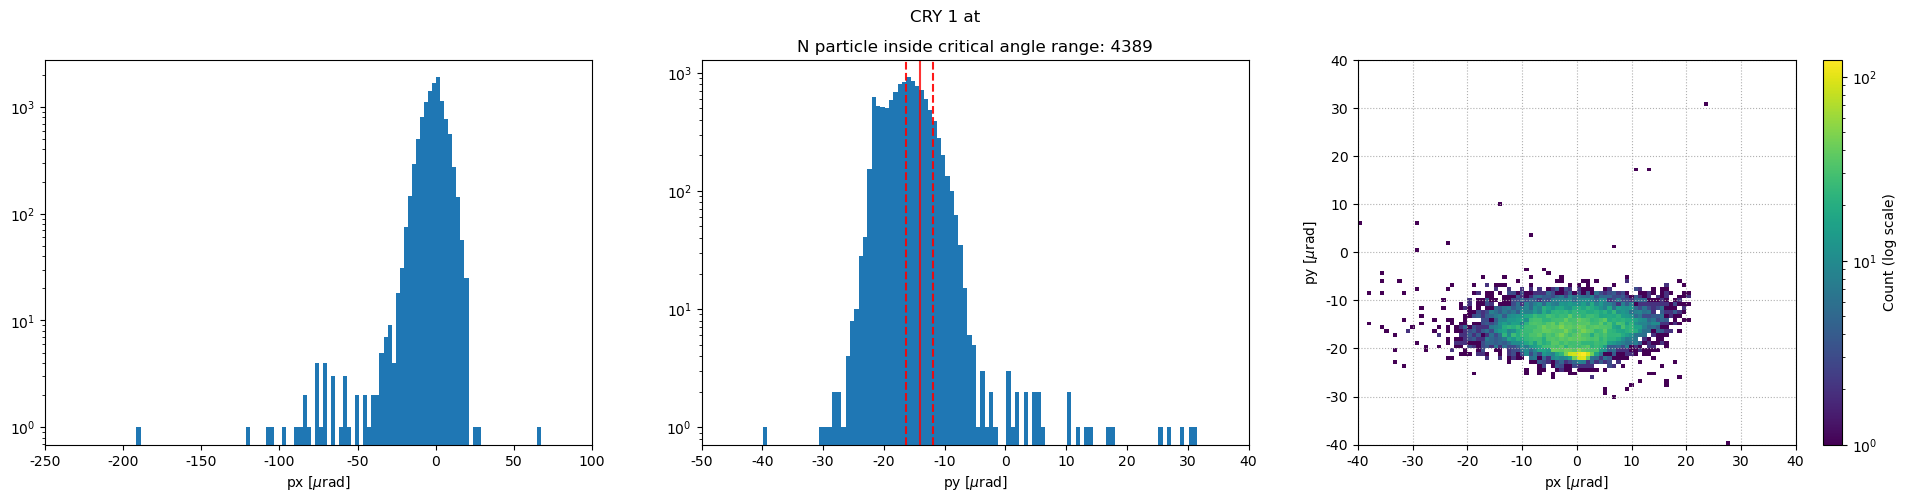

In [67]:

    fig1 = plt.figure( figsize=(24, 5))
    ax1 = fig1.add_subplot(1,3,1)
    ax1.hist(cry_impact_parts['px'], bins=100)
    ax1.set_xlabel(r'px [$\mu$rad]')
    ax1.set_ylabel("")
    ax1.set_yscale("log")
    precision = 6  # Set the desired precision
    ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
    #ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)


    ax2 = fig1.add_subplot(1,3,2)
    ax2.hist(cry_impact_parts['py'], bins=100) 
    ax2.set_xlabel(r'py [$\mu$rad]')
    ax2.set_ylabel('')
    ax2.set_yscale("log")
    ax2.axvline(py_central, color = 'red', linestyle = '-', alpha = 0.8)
    ax2.axvline(py_central + critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
    ax2.axvline(py_central - critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
    ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
    #ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)

    ax3 = fig1.add_subplot(1,3,3)
    h = ax3.hist2d(cry_impact_parts['px'], cry_impact_parts['py'], bins=100, norm=matplotlib.colors.LogNorm(), range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
    ax3.set_xlabel(r'px [$\mu$rad]')
    ax3.set_ylabel(r'py [$\mu$rad]')
    ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
    ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e6:.{0}f}" for y in plt.yticks()[0]])
    ax3.grid(linestyle=':')
    fig1.colorbar(h[3], orientation='vertical', label='Count (log scale)')


    chann = len(cry_impact_parts[(cry_impact_parts.py > py_central - critical_angle) & (cry_impact_parts.py < py_central + critical_angle)])
    print(chann, min(ax2.get_yticks()))


    ax2.set_title(f'N particle inside critical angle range: {chann}')

    fig1.suptitle('CRY 1 at')
    #ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    #ax3.ticklabel_format(style='sci', axis='y'
    # , scilimits=(0,0), useMathText=True)

    #fig1.savefig("./Outputdata/impact_angles_test.png")

Text(0.5, 0.98, 'CRY 1 at')

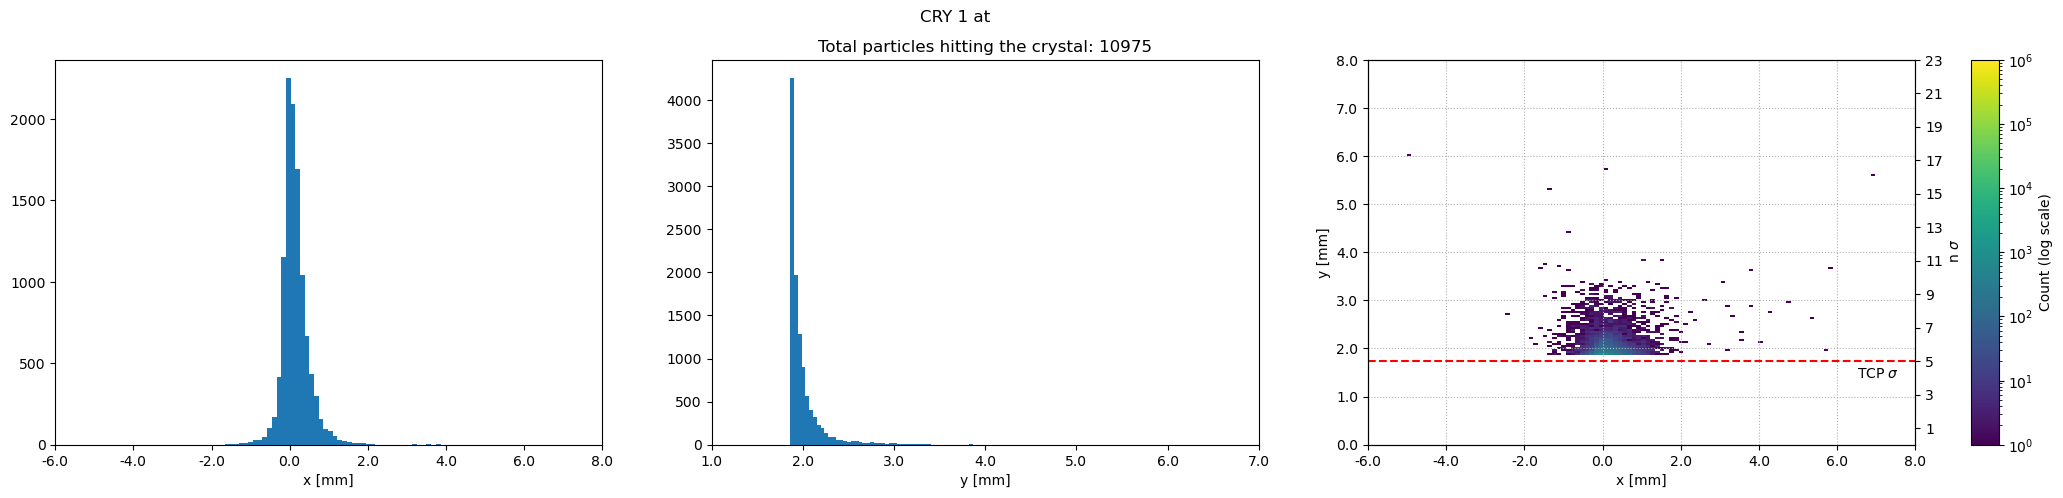

In [66]:
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes


    fig1 = plt.figure( figsize=(24, 5))
    ax1 = fig1.add_subplot(1,3,1)
    ax1.hist(cry_impact_parts['x'], bins=100)
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel("")
    #ax1.set_yscale("log")
    ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])


    ax2 = fig1.add_subplot(1,3,2)
    ax2.hist(cry_impact_parts['y'], bins=100) 
    ax2.set_xlabel('y [mm]')
    ax2.set_ylabel('')
    #ax2.set_yscale("log")
    ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax2.set_title(f'Total particles hitting the crystal: {len(cry_impact_parts)}')

    ax3 = fig1.add_subplot(1,3,3)
    h = ax3.hist2d(cry_impact_parts['x'], cry_impact_parts['y'], bins=100, norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 1e6))#, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
    ax3.set_xlabel(r'x [mm]')
    ax3.set_ylim(0,0.008)
    ax3.set_ylabel(r'y [mm]')
    ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e3:.{1}f}" for y in plt.yticks()[0]])

    axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )

    fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')


    ax3_tw = ax3.twinx()
    ticks = np.arange(1, max(ax3.get_yticks())/sigma+1, 2.0)
   
    ax3_tw.set_yticks(ticks)
    #ax3_tw.set_ybound(ax3.get_ybound())
    ax3_tw.set_ylabel(r' n $\sigma$')
    #ax3_tw.set_yticklabels([f"{x /sigma :.{0}f}"  for x in ticks])
    ax3_tw.axhline(5, color = 'r', linestyle = '--')
    ax3_tw.text( max(ax3.get_xticks())-1.5e-3, 4, r'TCP $\sigma$')
    ax3.grid(linestyle=':')

    fig1.suptitle('CRY 1 at')


    #fig1.savefig("./Outputdata/impact_position_test.png")

In [10]:
type(mon)

xtrack.monitors.particles_monitor.ParticlesMonitor

## Line Analysis

In [7]:
stop = line.element_names.index('tcla.a5l3.b2')
start = line.element_names.index('tcsg.5r3.b2')

In [13]:
for i in range(start-400, stop+400):
    if (line.element_names[i].endswith('b2') and type(line[i]) !=  xt.beam_elements.elements.Marker) or line.element_names[i].startswith('ip') or type(line[i]) ==  xt.monitors.particles_monitor.ParticlesMonitor:
        print(line.element_names[i], '\t\t', end_s-line.get_s_elements()[i], '\t\t', line[i].__class__.__name__ )

mbw.d6r3.b2 		 6847.564790687997 		 Multipole
tcp.6r3.b2 		 6842.070291762997 		 EverestCollimator
tcapa.6r3.b2 		 6832.893793852007 		 Drift
mbw.c6r3.b2 		 6829.5417939640065 		 Multipole
mbw.b6r3.b2 		 6825.306793964006 		 Multipole
mbw.a6r3.b2 		 6821.071793964005 		 Multipole
bpmwe.a5r3.b2 		 6818.556293964008 		 Drift
tcapd.5r3.b2 		 6817.771793964006 		 Drift
tcsg.5r3.b2 		 6808.948793964006 		 EverestCollimator
bpmw.5r3.b2 		 6789.838293964007 		 Drift
mcbwv.5r3.b2 		 6786.043793964007 		 Multipole
tccs.5r3.b2 		 6773.702000000001 		 EverestCrystal
bpmwe.4r3.b2 		 6714.710293964006 		 Drift
bpmw.4r3.b2 		 6687.165293964008 		 Drift
mcbwh.4r3.b2 		 6683.420793964007 		 Multipole
ip3_aper 		 6664.720793964007 		 LimitRectEllipse
ip3 		 6664.720793964007 		 Marker
target.4l3.b2 		 6653.34 		 EverestCollimator
tccp.4l3.b2 		 6653.334999999999 		 EverestCrystal
mcbwv.4l3.b2 		 6643.690793964008 		 Multipole
bpmw.4l3.b2 		 6642.200293964008 		 Drift
tcsg.4l3.b2 		 6622.365793964007 		

In [32]:
num = -1
line.element_names[line.element_names.index('ip5')+num]

'mymon5'

# Load LOSSMAPS

In [2]:
path = '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/'

In [3]:
n_test = 'TEST_B2V_align_test_CRY6.0'
prefix_name =  'TEST_B2V_align_test_CRY5.0_15_'

In [4]:
#n_old = int(subprocess.check_output("find "+ path + n_test +" -maxdepth 1 -mindepth 1 -type d | wc -l", shell=True))
#n = int(subprocess.check_output("find "+ path + n_test +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))
test_list = (subprocess.check_output("find "+ path +" -maxdepth 1 -mindepth 1 -type d | grep " + prefix_name, shell=True)).decode('ascii').strip().splitlines()

In [5]:
test_list

['/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733']

In [6]:
    for test_name in test_list:

        n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

        losses_json =[]

        for i in range(n_jobs):
            file_path = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/lossmap*.json', shell=True)).decode('ascii').strip()
            if os.path.exists(file_path):
                losses_json.append(file_path)

        n_jobs_verify  = len(losses_json)
        if n_jobs != n_jobs_verify:
            print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)

In [7]:
losses_json

['/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.0/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.1/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.2/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.3/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.4/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.5/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.6/Outputdata/lossmap_B2V.json',

In [8]:
ThisLM = lm.SimulatedLossMap(lmtype=lm.LMType.B2V, machine=lm.Machine.LHC)

In [9]:
#ThisLM.load_data_json(json_files=losses_json)
ThisLM.load_data_json(json_files=losses_json)

Maximum inefficiency in the DS is 2.04e-05.


pymadx.Tfs.Load> normal file


(<Figure size 1440x864 with 3 Axes>,
 array([<Axes: xlabel='S [m]', ylabel='Norm. inefficiency [arb. unit]'>,
        <Axes: >,
        <Axes: xlabel='S [m]', ylabel='Norm. inefficiency [arb. unit]'>],
       dtype=object))

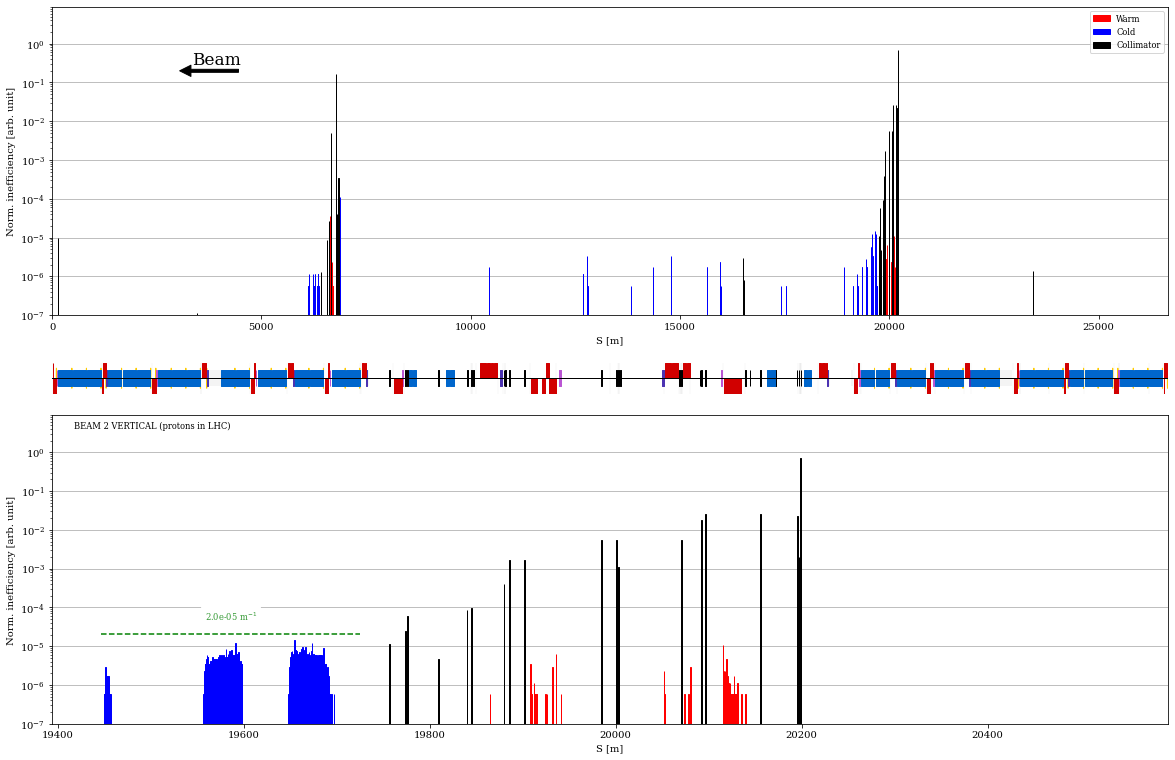

In [10]:
lm.plot_lossmap(ThisLM, zoom=True, layout="./input_files/layout_flat_top_b2.tfs",  outfile = "./Outputdata/TEST_False2.png")  #, outfile = "./Outputdata/Lossmap_outputs/"+outfile_name

In [11]:
lm.plot_lossmap_interactive(ThisLM, norm='total', layout="./input_files/layout_flat_top_b2.tfs")  #

Box(children=(Dropdown(description='norm', index=3, options=('none', 'max', 'coll_max', 'total'), value='total…

FigureWidget({
    'data': [{'base': 1e-17,
              'hovertemplate': 'S=%{x:.2f} m, value=%{y:1.2e}<br>%{hovertext}',
              'hovertext': array([ 166.,  167.,  168.,  169.,  170.,  171.,  172.,  173.,  174.,  175.,
                                   177.,  178.,  179.,  180.,  181.,  182.,  183.,  184.,  185.,  186.,
                                   187.,  188.,  189.,  190.,  191.,  192.,  193.,  194.,  195.,  196.,
                                   197.,  198.,  199.,  200.,  201.,  204.,  239.,  240.,  241.,  242.,
                                  1269., 1273., 1274., 1275., 1276., 1277., 1278., 1279., 1280., 1281.,
                                  1282., 1283., 1284., 1285., 1286., 1287., 1288., 1292., 1293., 1295.,
                                  1296., 1297., 1298., 1301., 1302., 1303., 1304., 1305., 1306., 1307.,
                                  1308., 1309., 1310., 1311., 1312., 1313., 1314., 1315., 1316., 1317.,
                                  1318., 131

In [12]:
losses_df = ThisLM._losses
losses_df[losses_df['name']=='tcla.a5l3.b2']

#'target.4l3.b2'

#loss_tcp = int(losses_df[losses_df['name']=='tcp.d6r7.b2']['losses'])

,s,name,losses_type,losses
162,6574.220794,tcla.a5l3.b2,Losses.COLL,152.0


### PYMADX

In [ ]:
loss_cry1/loss_tcp

In [ ]:
import pymadx
name_pymadx_layout = "input_files/layout_file_b2_flattop.tfs"  
tfsobject= pymadx.Data.Tfs(name_pymadx_layout)

pymadx.Tfs.Load> normal file


In [ ]:
for i in tfsobject:
    print(i['S'])

In [ ]:
if tfsobject.header['SEQUENCE'] == 'LHCB2':
    machine_length = tfsobject.header['LENGTH']
    print("------------- BEAM2 LAYOUT INVERTED -------------")
    for i in range(len(tfsobject)):
        old_s = tfsobject[i]['S']
        tfsobject.EditComponent(i,'S', machine_length-old_s) 

In [ ]:
for i in tfsobject:
    print(i['S'])

In [ ]:
def _get_twiss_header(tfsfile):
    header = None
    line_no = 0

    gzipped = tfsfile.endswith(".gz")
    fopen = gzip.open if gzipped else open

    flag = "rb" if gzipped else "r"
    with fopen(tfsfile, flag) as filein:
        for idx, line in enumerate(filein):
            if gzipped:
                line = line.decode("utf-8")
            if line.startswith("*"):  # This is the header line, preamble lines start with @
                header = line.replace("*", "").strip().split()  # Strip the comment char
                line_no = idx + 1  # As zero counted
                break  # End the loop early - information found

    return header, line_no



def _load_layout_tfs(tfsfile):
    header, header_line_no = _get_twiss_header(tfsfile)

    required_columns = {"KEYWORD", "S", "L", "K1L", "NAME"}

    if not required_columns.issubset(set(required_columns)):
        raise KeyError("The required columns in the MAD-X"
                       " TFS file are: {}".format(" ".join(list(required_columns))))

    twiss = pd.read_csv(tfsfile, delim_whitespace=True, skiprows=header_line_no+1,
                        index_col=False, names=header)

    twiss = twiss[list(required_columns)] # Reduce the data fields
    twiss["NAME"] = twiss["NAME"].str.upper() # Make the names uppercase
    twiss = twiss.set_index("NAME")

    return twiss



def _make_layout_plotly(tfsfile):
    tfs_df = _load_layout_tfs(tfsfile)
    tfs_df = tfs_df[(tfs_df["L"] > 0) & (tfs_df["KEYWORD"] != "DRIFT")]

    lim = (tfs_df["S"].min(), tfs_df["S"].max())
    centres = tfs_df["S"] - tfs_df["L"]/2


In [ ]:
'LENGTH' in _get_twiss_header(name_pymadx_layout)[0]

False

In [ ]:
_get_twiss_header(name_pymadx_layout)

(['NAME',
  'KEYWORD',
  'S',
  'L',
  'K0L',
  'K1L',
  'K2L',
  'K3L',
  'K4L',
  'K1SL',
  'K2SL',
  'K3SL',
  'K4SL',
  'HKICK',
  'VKICK',
  'BETX',
  'BETY',
  'ALFX',
  'ALFY',
  'MUX',
  'MUY',
  'DX',
  'DY',
  'DPX',
  'DPY',
  'R11',
  'R12',
  'R22',
  'R21',
  'X',
  'PX',
  'Y',
  'PY',
  'T',
  'PT',
  'DELTAP',
  'VOLT',
  'LAG',
  'HARMON',
  'FREQ',
  'E1',
  'E2',
  'APERTYPE',
  'APER_1',
  'APER_2',
  'APER_3',
  'APER_4',
  'TILT',
  'ANGLE'],
 51)

In [ ]:
double* crystal(RandomRutherfordData rng, LocalParticle* part, double x, double xp, double z, double zp, double s, double p, 
                double x0, double xp0, double zlm, double s_imp, int isimp, double val_part_hit, double val_part_abs, 
                double val_part_impact, double val_part_indiv, double c_length, CrystalMaterialData material, double nhit, 
                double nabs, double cry_tilt, double  cry_rcurv, double  cry_bend, double  cry_alayer, double  cry_xmax, 
                double cry_ymax, double cry_orient, double cry_miscut, double iProc, 
                double n_chan, double n_VR, double n_amorphous) {

In [ ]:
   double* crystal_result = crystal(rng, part, x,
                                xp,
                                z,
                                zp,
                                s,
                                p,
                                x0,
                                xp0,
                                zlm,
                                s_imp,
                                isimp,
                                val_part_hit,
                                val_part_abs,
                                val_part_impact,
                                val_part_indiv,
                                length,
                                material,
                                nhit,
                                nabs,
                                cry_tilt,
                                cry_rcurv,
                                cry_bend,
                                cry_alayer,
                                cry_xmax,
                                cry_ymax,
                                cry_orient,
                                cry_miscut,
                                iProc,
                                n_chan,
                                n_VR,
                                n_amorphous
                                );

In [7]:
def process_arguments(**kwargs):

        another_function(**kwargs)

def another_function(**kwargs):
    # Do something with the arguments
    print("Received arguments:")
    for key, value in kwargs.items():
        print(f"{key}: {value}")

# Example usage
process_arguments(arg1='value1', arg2='value2')

Received arguments:
arg1: value1
arg2: value2


In [1]:
import numpy as np

arr = np.array([2, 1, 3, 2, 4, 3, 5])
unique_elements = np.unique(arr)

print(unique_elements)

[1 2 3 4 5]


In [3]:
unique_elements, counts = np.unique(arr, return_counts=True)
print(unique_elements)
print(counts)

[1 2 3 4 5]
[1 2 2 1 1]


In [4]:

repeated_indices = np.where(counts > 1)[0]
if len(repeated_indices) > 0:
    print(f"There are repeated numbers in the array at indices: {repeated_indices}\n", len(unique_elements), "\n",unique_elements)


There are repeated numbers in the array at indices: [1 2]
 5 
 [1 2 3 4 5]


In [7]:
repeated_indices = np.where(counts > 1)
repeated_indices

(array([1, 2]),)

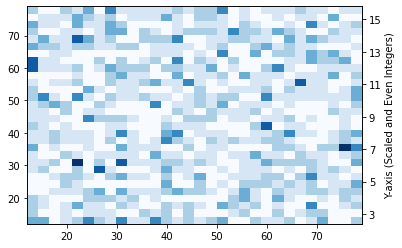

In [16]:
# Sample data for the 2D histogram
data = np.random.randint(12, 80, (1000, 2))

# Create a 2D histogram
fig, ax = plt.subplots()
hist = ax.hist2d(data[:, 0], data[:, 1], bins=30, cmap='Blues')

# Clone the y-axis with twinx()
ax2 = ax.twinx()

# Rescale the y-axis by dividing it by a factor of 5
ax2.set_ylim(ax.get_ylim()[0] / 5, ax.get_ylim()[1] / 5)

# Show only even integer values on the right axis
ax2.set_yticks(np.arange(np.ceil(ax2.get_ylim()[0]), np.floor(ax2.get_ylim()[1]) + 1, 2))

# Set the label for the right y-axis
ax2.set_ylabel('Y-axis (Scaled and Even Integers)')

# Show the plot
plt.show()

In [15]:
print(ax.get_ylim()[0] / 5, ax.get_ylim()[1] / 5)

2.4 15.8


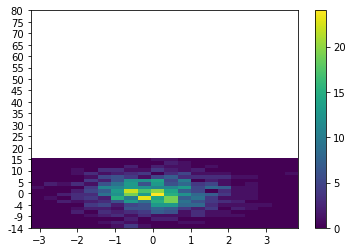

In [8]:


# Rescale the y-axis by a factor of 5
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 5)

# Set y-ticks as integer values
yticks = np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 1, 5)
ax.set_yticks(yticks)
ax.set_yticklabels(map(int, yticks))

# Add colorbar for better interpretation
plt.colorbar()

# Show the plot
plt.show()

In [17]:
import pandas as pd

def mean_of_column_within_range(dataframe, column_name, lower_limit=None, upper_limit=None):
   

    # Apply filtering if lower and/or upper limits are provided
    filtered_data = dataframe[column_name]
    if lower_limit is not None:
        filtered_data = filtered_data[filtered_data >= lower_limit]
    if upper_limit is not None:
        filtered_data = filtered_data[filtered_data <= upper_limit]

    # Calculate the mean of the filtered data
    mean_value = filtered_data.mean()

    return mean_value

# Example usage:
# Assuming 'df' is your DataFrame
# mean_value = mean_of_column_within_range(df, 'your_column_name', lower_limit=10, upper_limit=50)


In [2]:
def load_colldb_new(filename):
    with open(filename, "r") as infile:
        coll_data_string = ""
        family_settings = {}
        family_types = {}
        onesided = {}
        tilted = {}
        bend = {}
        xdim = {}
        ydim = {}

        for l_no, line in enumerate(infile):
            if line.startswith("#"):
                continue  # Comment
            if len(line.strip()) == 0:
                continue  # Empty line
            sline = line.split()
            if len(sline) < 6 or sline[0].lower() == "crystal" or sline[0].lower() == "target":
                if sline[0].lower() == "nsig_fam":
                    family_settings[sline[1]] = sline[2]
                    family_types[sline[1]] = sline[3]
                elif sline[0].lower() == "onesided":
                    onesided[sline[1]] = int(sline[2])
                elif sline[0].lower() == "tilted":
                    tilted[sline[1]] = [float(sline[2]), float(sline[3])]
                elif sline[0].lower() == "crystal":
                    bend[sline[1]] = float(sline[2])
                    xdim[sline[1]] = float(sline[3])
                    ydim[sline[1]] = float(sline[4])
                elif sline[0].lower() == "target":
                    xdim[sline[1]] = float(sline[2])
                    ydim[sline[1]] = float(sline[3])
                elif sline[0].lower() == "settings":
                    pass  # Acknowledge and ignore this line
                else:
                    raise ValueError(f"Unknown setting {line}")
            else:
                coll_data_string += line

    names = ["name", "opening", "material", "length", "angle", "offset"]

    df = pd.read_csv(io.StringIO(coll_data_string), delim_whitespace=True,
                     index_col=False, skip_blank_lines=True, names=names)

    df["angle"] = df["angle"] 
    df["name"] = df["name"].str.lower() # Make the names lowercase for easy processing
    df["nsigma"] = df["opening"].apply(lambda s: float(family_settings.get(s, s)))
    df["type"] = df["opening"].apply(lambda s: family_types.get(s, "UNKNOWN"))
    df["side"] = df["name"].apply(lambda s: onesided.get(s, 0))
    df["bend"] = df["name"].apply(lambda s: bend.get(s, 0))
    df["xdim"] = df["name"].apply(lambda s: xdim.get(s, 0))
    df["ydim"] = df["name"].apply(lambda s: ydim.get(s, 0))
    df["tilt_left"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[0]))
    df["tilt_right"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[1]))
    df = df.set_index("name").T

    # Ensure the collimators marked as one-sided or tilted are actually defined
    defined_set = set(df.columns) # The data fram was transposed so columns are names
    onesided_set = set(onesided.keys())
    tilted_set = set(tilted.keys())
    if not onesided_set.issubset(defined_set):
        different = onesided_set - defined_set
        raise SystemExit('One-sided collimators not defined: {}'.format(", ".join(different)))
    if not tilted_set.issubset(defined_set):
        different = tilted_set - defined_set
        raise SystemExit('Tilted collimators not defined: {}'.format(",".join(different)))
    return df.T


def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers


In [ ]:
    import io
    import scipy
    config_file = 'config_sim.yaml'
    
    with open(config_file, 'r') as stream:
        config_dict = yaml.safe_load(stream)

    # Configure run parameters
    run_dict = config_dict['run']

    beam          = run_dict['beam']
    plane         = run_dict['plane']

    num_turns     = run_dict['turns']
    num_particles = run_dict['nparticles']
    engine        = run_dict['engine']

    TTCS_align_angle_step = run_dict['TTCS_align_angle_step']

    mode = run_dict['mode']
    print('\nMode: ', mode, '\n')


    # Setup input files
    file_dict = config_dict['input_files']

    coll_file = os.path.expandvars(file_dict['collimators'])
    line_file = os.path.expandvars(file_dict[f'line_b{beam}'])
    
    print('Input files:\n', line_file, '\n', coll_file, '\n')

    if coll_file.endswith('.yaml'):
        with open(coll_file, 'r') as stream:
            coll_dict = yaml.safe_load(stream)['collimators']['b'+config_dict['run']['beam']]
    if coll_file.endswith('.data'):
        coll_dict = load_colldb_new(coll_file).to_dict('index')

    context = xo.ContextCpu(omp_num_threads='auto')


    # Define output path
    path_out = Path.cwd() / 'Outputdata'

    if not path_out.exists():
        os.makedirs(path_out)


    # Load from json
    line = xt.Line.from_json(line_file)

    end_s = line.get_length()

    TCCS_name = 'tccs.5r3.b2'
    TCCP_name = 'tccp.4l3.b2'
    TARGET_name = 'target.4l3.b2'
    TCLA_name = 'tcla.a5l3.b2'

    TCCS_loc = end_s - 6773.7 #6775
    TCCP_loc = end_s - 6653.3 #6655
    TARGET_loc = end_s - (6653.3 + coll_dict[TCCP_name]["length"]/2 + coll_dict[TARGET_name]["length"]/2)
    TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name='tccs.5r3.b2')
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccs.5r3.b2_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name='tccp.4l3.b2')
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccp.4l3.b2_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name='target.4l3.b2')
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='target.4l3.b2_aper')


    TCCS_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    TARGET_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
    dx = 1e-11
    line.insert_element(at_s = TCCS_loc - coll_dict[TCCS_name]["length"]/2 - dx, element=TCCS_monitor, name='TCCS_monitor')
    line.insert_element(at_s = TARGET_loc - coll_dict[TARGET_name]["length"]/2 - dx, element=TARGET_monitor, name='TARGET_monitor')


    bad_aper = find_bad_offset_apertures(line)
    print('Bad apertures : ', bad_aper)
    print('Replace bad apertures with Marker')
    for name in bad_aper.keys():
        line.element_dict[name] = xt.Marker()
        print(name, line.get_s_position(name), line.element_dict[name])

    # Aperture model check
    print('\nAperture model check on imported model:')
    df_imported = line.check_aperture()
    assert not np.any(df_imported.has_aperture_problem)


    # Initialise collmanager
    if coll_file.endswith('.yaml'):
        coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)
    elif coll_file.endswith('.data'):
        coll_manager = xc.CollimatorManager.from_SixTrack(coll_file, line=line, _context=context, ignore_crystals=False, nemitt_x = 2.5e-6,  nemitt_y = 2.5e-6)
        # switch on cavities
        speed = line.particle_ref._xobject.beta0[0]*scipy.constants.c
        harmonic_number = 35640
        voltage = 12e6/len(line.get_elements_of_type(xt.Cavity)[1])
        frequency = harmonic_number * speed /line.get_length()
        for side in ['l', 'r']:
            for cell in ['a','b','c','d']:
                line[f'acsca.{cell}5{side}4.b2'].voltage = voltage
                line[f'acsca.{cell}5{side}4.b2'].frequency = frequency

    # Install collimators into line
    if engine == 'everest':
        coll_names = coll_manager.collimator_names

        if mode == 'cry_black_absorbers':
            black_absorbers = ['target.4l3.b2', 'tccs.5r3.b2']
        elif mode == 'angular_scan' or mode == 'target_absorber': 
            black_absorbers = ['target.4l3.b2',]
        else: 
            black_absorbers = []

        everest_colls = [name for name in coll_names if name not in black_absorbers]
        coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
        coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)
    else:
        raise ValueError(f"Unknown scattering engine {engine}!")


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

        
    # Build the tracker
    coll_manager.build_tracker()


    # Set the collimator openings based on the colldb,
    # or manually override with the option gaps={collname: gap}
    coll_manager.set_openings()


    if mode == 'angular_scan':
        print("\nTCCS aligned to beam: ", line[TCCS_name].align_angle)
        #line[TTCS_name].align_angle = TTCS_align_angle_step

        line[TCCS_name].align_angle = line[TCCS_name].align_angle + TTCS_align_angle_step
        print("TCCS align angle incremented by step: ", line[TCCS_name].align_angle)


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

In [7]:
import io
def load_colldb_new(filename):
    with open(filename, "r") as infile:
        coll_data_string = ""
        family_settings = {}
        family_types = {}
        onesided = {}
        tilted = {}
        bend = {}
        xdim = {}
        ydim = {}

        for l_no, line in enumerate(infile):
            if line.startswith("#"):
                continue  # Comment
            if len(line.strip()) == 0:
                continue  # Empty line
            sline = line.split()
            if len(sline) < 6 or sline[0].lower() == "crystal" or sline[0].lower() == "target":
                if sline[0].lower() == "nsig_fam":
                    family_settings[sline[1]] = sline[2]
                    family_types[sline[1]] = sline[3]
                elif sline[0].lower() == "onesided":
                    onesided[sline[1]] = int(sline[2])
                elif sline[0].lower() == "tilted":
                    tilted[sline[1]] = [float(sline[2]), float(sline[3])]
                elif sline[0].lower() == "crystal":
                    bend[sline[1]] = float(sline[2])
                    xdim[sline[1]] = float(sline[3])
                    ydim[sline[1]] = float(sline[4])
                elif sline[0].lower() == "target":
                    xdim[sline[1]] = float(sline[2])
                    ydim[sline[1]] = float(sline[3])
                elif sline[0].lower() == "settings":
                    pass  # Acknowledge and ignore this line
                else:
                    raise ValueError(f"Unknown setting {line}")
            else:
                coll_data_string += line

    names = ["name", "opening", "material", "length", "angle", "offset"]

    df = pd.read_csv(io.StringIO(coll_data_string), delim_whitespace=True,
                     index_col=False, skip_blank_lines=True, names=names)

    df["angle"] = df["angle"] 
    df["name"] = df["name"].str.lower() # Make the names lowercase for easy processing
    df["gap"] = df["opening"].apply(lambda s: float(family_settings.get(s, s)))
    df["type"] = df["opening"].apply(lambda s: family_types.get(s, "UNKNOWN"))
    df["side"] = df["name"].apply(lambda s: onesided.get(s, 0))
    df["bend"] = df["name"].apply(lambda s: bend.get(s, 0))
    df["xdim"] = df["name"].apply(lambda s: xdim.get(s, 0))
    df["ydim"] = df["name"].apply(lambda s: ydim.get(s, 0))
    df["tilt_left"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[0]))
    df["tilt_right"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[1]))
    df = df.set_index("name").T

    # Ensure the collimators marked as one-sided or tilted are actually defined
    defined_set = set(df.columns) # The data fram was transposed so columns are names
    onesided_set = set(onesided.keys())
    tilted_set = set(tilted.keys())
    if not onesided_set.issubset(defined_set):
        different = onesided_set - defined_set
        raise SystemExit('One-sided collimators not defined: {}'.format(", ".join(different)))
    if not tilted_set.issubset(defined_set):
        different = tilted_set - defined_set
        raise SystemExit('Tilted collimators not defined: {}'.format(",".join(different)))
    return df.T

In [12]:
    config_file = 'config_sim.yaml'
    
    with open(config_file, 'r') as stream:
        config_dict = yaml.safe_load(stream)

    # Configure run parameters
    run_dict = config_dict['run']

    beam          = run_dict['beam']
    plane         = run_dict['plane']

    num_turns     = run_dict['turns']
    num_particles = run_dict['nparticles']
    engine        = run_dict['engine']
    
    seed          = run_dict['seed']

    TTCS_align_angle_step = run_dict['TTCS_align_angle_step']

    mode = run_dict['mode']
    print('\nMode: ', mode, '\n', 'Seed: ', seed, '\n')


    # Setup input files
    file_dict = config_dict['input_files']

    #coll_file = './input_files/flat_top.yaml'
    coll_file = os.path.expandvars(file_dict['collimators'])
    line_file = os.path.expandvars(file_dict[f'line_b{beam}'])
    
    print('Input files:\n', line_file, '\n', coll_file, '\n')

    if coll_file.endswith('.yaml'):
        with open(coll_file, 'r') as stream:
            coll_dict = yaml.safe_load(stream)['collimators']['b'+config_dict['run']['beam']]
    if coll_file.endswith('.data'):
        coll_dict = load_colldb_new(coll_file).to_dict('index')



Mode:  target_absorber 
 Seed:  12345 

Input files:
 /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/input_files/HL_IR7_IR3_rematched/b4_sequence_patched.json 
 /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/input_files/CollDB_HL_tight_b4.data 



In [13]:
coll_dict

{'tclpx.4l1.b2': {'opening': 'tclp',
  'material': 'Iner',
  'length': 1.0,
  'angle': 0.0,
  'offset': 0.0,
  'gap': 16.4,
  'type': 'TERTIARY',
  'side': 0,
  'bend': 0.0,
  'xdim': 0.0,
  'ydim': 0.0,
  'tilt_left': 0.0,
  'tilt_right': 0.0},
 'tcl.5l1.b2': {'opening': 'tclp',
  'material': 'CU',
  'length': 1.0,
  'angle': 0.0,
  'offset': 0.0,
  'gap': 16.4,
  'type': 'TERTIARY',
  'side': 0,
  'bend': 0.0,
  'xdim': 0.0,
  'ydim': 0.0,
  'tilt_left': 0.0,
  'tilt_right': 0.0},
 'tcl.6l1.b2': {'opening': 'tclp',
  'material': 'Iner',
  'length': 1.0,
  'angle': 0.0,
  'offset': 0.0,
  'gap': 16.4,
  'type': 'TERTIARY',
  'side': 0,
  'bend': 0.0,
  'xdim': 0.0,
  'ydim': 0.0,
  'tilt_left': 0.0,
  'tilt_right': 0.0},
 'tctph.4r2.b2': {'opening': 'tcth2',
  'material': 'Iner',
  'length': 1.0,
  'angle': 0.0,
  'offset': 0.0,
  'gap': 43.8,
  'type': 'TERTIARY',
  'side': 0,
  'bend': 0.0,
  'xdim': 0.0,
  'ydim': 0.0,
  'tilt_left': 0.0,
  'tilt_right': 0.0},
 'tctpv.4r2.b2': {'op

In [ ]:
import json
import numpy as np
from pathlib import Path
import sys
import os
import yaml
import pandas as pd
import pickle

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc
import scipy
import io 




# ---------------------------- LOADING FUNCTIONS ----------------------------


def load_colldb_new(filename):
    with open(filename, "r") as infile:
        coll_data_string = ""
        family_settings = {}
        family_types = {}
        onesided = {}
        tilted = {}
        bend = {}
        xdim = {}
        ydim = {}

        for l_no, line in enumerate(infile):
            if line.startswith("#"):
                continue  # Comment
            if len(line.strip()) == 0:
                continue  # Empty line
            sline = line.split()
            if len(sline) < 6 or sline[0].lower() == "crystal" or sline[0].lower() == "target":
                if sline[0].lower() == "nsig_fam":
                    family_settings[sline[1]] = sline[2]
                    family_types[sline[1]] = sline[3]
                elif sline[0].lower() == "onesided":
                    onesided[sline[1]] = int(sline[2])
                elif sline[0].lower() == "tilted":
                    tilted[sline[1]] = [float(sline[2]), float(sline[3])]
                elif sline[0].lower() == "crystal":
                    bend[sline[1]] = float(sline[2])
                    xdim[sline[1]] = float(sline[3])
                    ydim[sline[1]] = float(sline[4])
                elif sline[0].lower() == "target":
                    xdim[sline[1]] = float(sline[2])
                    ydim[sline[1]] = float(sline[3])
                elif sline[0].lower() == "settings":
                    pass  # Acknowledge and ignore this line
                else:
                    raise ValueError(f"Unknown setting {line}")
            else:
                coll_data_string += line

    names = ["name", "opening", "material", "length", "angle", "offset"]

    df = pd.read_csv(io.StringIO(coll_data_string), delim_whitespace=True,
                     index_col=False, skip_blank_lines=True, names=names)

    df["angle"] = df["angle"] 
    df["name"] = df["name"].str.lower() # Make the names lowercase for easy processing
    df["gap"] = df["opening"].apply(lambda s: float(family_settings.get(s, s)))
    df["type"] = df["opening"].apply(lambda s: family_types.get(s, "UNKNOWN"))
    df["side"] = df["name"].apply(lambda s: onesided.get(s, 0))
    df["bend"] = df["name"].apply(lambda s: bend.get(s, 0))
    df["xdim"] = df["name"].apply(lambda s: xdim.get(s, 0))
    df["ydim"] = df["name"].apply(lambda s: ydim.get(s, 0))
    df["tilt_left"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[0]))
    df["tilt_right"] = df["name"].apply(lambda s: np.deg2rad(tilted.get(s, [0, 0])[1]))
    df = df.set_index("name").T

    # Ensure the collimators marked as one-sided or tilted are actually defined
    defined_set = set(df.columns) # The data fram was transposed so columns are names
    onesided_set = set(onesided.keys())
    tilted_set = set(tilted.keys())
    if not onesided_set.issubset(defined_set):
        different = onesided_set - defined_set
        raise SystemExit('One-sided collimators not defined: {}'.format(", ".join(different)))
    if not tilted_set.issubset(defined_set):
        different = tilted_set - defined_set
        raise SystemExit('Tilted collimators not defined: {}'.format(",".join(different)))
    return df.T


def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers



# ---------------------------- MAIN ----------------------------




config_file = 'config_sim.yaml'

with open(config_file, 'r') as stream:
    config_dict = yaml.safe_load(stream)

# Configure run parameters
run_dict = config_dict['run']

beam          = run_dict['beam']
plane         = run_dict['plane']

num_turns     = run_dict['turns']
num_particles = run_dict['nparticles']
engine        = run_dict['engine']

seed          = run_dict['seed']

TTCS_align_angle_step = run_dict['TTCS_align_angle_step']

mode = run_dict['mode']
print('\nMode: ', mode, '\n', 'Seed: ', seed, '\n')


# Setup input files
file_dict = config_dict['input_files']

coll_file = os.path.expandvars(file_dict['collimators'])
line_file = os.path.expandvars(file_dict[f'line_b{beam}'])

print('Input files:\n', line_file, '\n', coll_file, '\n')

if coll_file.endswith('.yaml'):
    with open(coll_file, 'r') as stream:
        coll_dict = yaml.safe_load(stream)['collimators']['b'+config_dict['run']['beam']]
if coll_file.endswith('.data'):
    coll_dict = load_colldb_new(coll_file).to_dict('index')

context = xo.ContextCpu(omp_num_threads='auto')


# Define output path
path_out = Path.cwd() / 'Outputdata'

if not path_out.exists():
    os.makedirs(path_out)


# Load from json
line = xt.Line.from_json(line_file)

end_s = line.get_length()

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'

TCCS_loc = end_s - 6773.7 #6775
TCCP_loc = end_s - 6653.3 #6655
TARGET_loc = end_s - (6653.3 + coll_dict[TCCP_name]["length"]/2 + coll_dict[TARGET_name]["length"]/2)
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name='tccs.5r3.b2')
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccs.5r3.b2_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name='tccp.4l3.b2')
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccp.4l3.b2_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name='target.4l3.b2')
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='target.4l3.b2_aper')


TCCS_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
TARGET_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
dx = 1e-11
line.insert_element(at_s = TCCS_loc - coll_dict[TCCS_name]["length"]/2 - dx, element=TCCS_monitor, name='TCCS_monitor')
line.insert_element(at_s = TARGET_loc - coll_dict[TARGET_name]["length"]/2 - dx, element=TARGET_monitor, name='TARGET_monitor')


bad_aper = find_bad_offset_apertures(line)
print('Bad apertures : ', bad_aper)
print('Replace bad apertures with Marker')
for name in bad_aper.keys():
    line.element_dict[name] = xt.Marker()
    print(name, line.get_s_position(name), line.element_dict[name])

# Aperture model check
print('\nAperture model check on imported model:')
df_imported = line.check_aperture()
assert not np.any(df_imported.has_aperture_problem)


# Initialise collmanager
if coll_file.endswith('.yaml'):
    coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)
elif coll_file.endswith('.data'):
    coll_manager = xc.CollimatorManager.from_SixTrack(coll_file, line=line, _context=context, ignore_crystals=False, nemitt_x = 2.5e-6,  nemitt_y = 2.5e-6)
    # switch on cavities
    speed = line.particle_ref._xobject.beta0[0]*scipy.constants.c
    harmonic_number = 35640
    voltage = 12e6/len(line.get_elements_of_type(xt.Cavity)[1])
    frequency = harmonic_number * speed /line.get_length()
    for side in ['l', 'r']:
        for cell in ['a','b','c','d']:
            line[f'acsca.{cell}5{side}4.b2'].voltage = voltage
            line[f'acsca.{cell}5{side}4.b2'].frequency = frequency

# Install collimators into line
if engine == 'everest':
    coll_names = coll_manager.collimator_names

    if mode == 'cry_black_absorbers':
        black_absorbers = ['target.4l3.b2', 'tccs.5r3.b2']
    elif mode == 'angular_scan' or mode == 'target_absorber': 
        black_absorbers = ['target.4l3.b2',]
    else: 
        black_absorbers = []

    everest_colls = [name for name in coll_names if name not in black_absorbers]
    coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
    coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)
else:
    raise ValueError(f"Unknown scattering engine {engine}!")


# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)

    
# Build the tracker
coll_manager.build_tracker()


# Set the collimator openings based on the colldb,
# or manually override with the option gaps={collname: gap}
coll_manager.set_openings()


if mode == 'angular_scan':
    print("\nTCCS aligned to beam: ", line[TCCS_name].align_angle)
    #line[TTCS_name].align_angle = TTCS_align_angle_step

    line[TCCS_name].align_angle = line[TCCS_name].align_angle + TTCS_align_angle_step
    print("TCCS align angle incremented by step: ", line[TCCS_name].align_angle)


# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)

# Printout useful informations
idx_TCCS = line.element_names.index(TCCS_name)
idx_TARGET = line.element_names.index(TARGET_name)
idx_TCCP = line.element_names.index(TCCP_name)

print(f"\nParticleAnalysis(element_type=\'crystal\', n_sigma={coll_dict[ TCCS_name]['gap']}, length={ coll_dict[ TCCS_name]['length']}, ydim={ coll_dict[ TCCS_name]['xdim']}, xdim={ coll_dict[ TCCS_name]['ydim']}, bend={ coll_dict[ TCCS_name]['bend']}, align_angle={ line.elements[idx_TCCS].align_angle}, jaw_L={line.elements[idx_TCCS].jaw_L}, line_idx={ idx_TCCS})")
print(f"ParticleAnalysis(element_type=\'target\', n_sigma={ coll_dict[TARGET_name]['gap']}, length={ coll_dict[ TARGET_name]['length']}, ydim={ coll_dict[ TARGET_name]['xdim']}, xdim={ coll_dict[ TARGET_name]['ydim']}, jaw_L={ line.elements[ idx_TARGET].jaw_L}, line_idx={ idx_TARGET})")
print(f"ParticleAnalysis(element_type=\'crystal\', n_sigma={ coll_dict[TCCP_name]['gap']}, length={ coll_dict[ TCCP_name]['length']}, ydim={ coll_dict[ TCCP_name]['xdim']}, xdim={ coll_dict[ TCCP_name]['ydim']}, bend={ coll_dict[ TCCP_name]['bend']}, jaw_L={ line.elements[ idx_TCCP].jaw_L}, line_idx={idx_TCCP})")






Mode:  target_absorber 
 Seed:  12345 

Input files:
 /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/input_files/flat_top_b2.json 
 /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/input_files/flat_top.yaml 



Loading line from dict:   0%|          | 0/105797 [00:00<?, ?it/s]

Done loading line from dict.           
Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.04, 0.04, -0.04, 0.04, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)

Aperture model check on imported model:


Checking aperture:   0%|          | 0/105810 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tcl.4l1.b2           as EverestCollimator
Installing tcl.5l1.b2           as EverestCollimator
Installing tcl.6l1.b2           as EverestCollimator
Installing tctph.4r8.b2         as EverestCollimator
Installing tctpv.4r8.b2         as EverestCollimator
Installing tdisa.a4r8.b2        as EverestCollimator
Installing tdisb.a4r8.b2        as EverestCollimator
Installing tdisc.a4r8.b2        as EverestCollimator
Installing tclia.4l8            as EverestCollimator
Installing tclib.6l8.b2         as EverestCollimator
Installing tcp.d6r7.b2          as EverestCollimator
Installing tcp.c6r7.b2          as EverestCollimator
Installing tcp.b6r7.b2          as EverestCollimator
Installing tcsg.a6r7.b2         as EverestCollimator
Installing tcsg.b5r7.b2      

Checking aperture:   0%|          | 0/105546 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


: 

In [2]:
# Generate initial pencil distribution on horizontal collimator
tcp  = f"tcp.{'c' if plane=='H' else 'd'}6{'l' if beam=='1' else 'r'}7.b{beam}"
part = coll_manager.generate_pencil_on_collimator(tcp, num_particles=num_particles, impact_parameter=1e-5)

Collimator tcp.d6r7.b2 is diverging.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [1]:
tw = line.twiss()

NameError: name 'line' is not defined

In [11]:
beta_y_TCCS = tw[:,TCCS_name]['bety'][0]
beta_y_TCCP = tw[:,TCCP_name]['bety'][0]
beta_y_TARGET = tw[:,TARGET_name]['bety'][0]
normalized_emittance = 2.5e-6
beta_rel = line.particle_ref._xobject.beta0[0]
gamma = line.particle_ref._xobject.gamma0[0]
energy = line.particle_ref._xobject.p0c[0]

emittance_phy = normalized_emittance/(beta_rel*gamma)

sigma_TCCS = np.sqrt(emittance_phy*beta_y_TCCS)
sigma_TCCP = np.sqrt(emittance_phy*beta_y_TCCP)
sigma_TARGET = np.sqrt(emittance_phy*beta_y_TARGET)

sigma

0.00028111076872336534

In [12]:
0.0020239975348795404/7.2

0.0002811107687332695

In [13]:
12e6/8

1500000.0

In [3]:
line[tcp].ref_y

1.0432412134074192e-06

In [4]:
line[tcp].jaw_LU + line[tcp].ref_y - 0.0023099766103719293

-1.0000000000000026e-05

In [10]:
line[tcp]

EverestCollimator(inactive_front=0.0, active_length=0.6, inactive_back=0.0, jaw_L=0.002298933369158522, jaw_R=-0.002298933369158522, ref_x=1.7947587477006948e-06, ref_y=1.0432412134074192e-06, sin_zL=1.0, cos_zL=6.123233995736766e-17, sin_zR=1.0, cos_zR=6.123233995736766e-17, sin_yL=0.0, cos_yL=1.0, tan_yL=1.0, sin_yR=0.0, cos_yR=1.0, tan_yR=1.0, _side=0, active=1, _internal_record_id=RecordIdentifier(buffer_id=0, offset=0), _material=Material(Z=6.65, A=13.53, density=2.5, excitation_energy=8.71e-08, nuclear_radius=0.25, nuclear_elastic_slope=76.7, cross_section=[3.62e-01 2.47e-01 0.00e+00 0.00e+00 0.00e+00 9.40e-05], hcut=0.02, name=MolybdenumGraphite, radiation_length=0.1193), rutherford_rng=RandomRutherford(lower_val=0.0009982, upper_val=0.02, A=0.0012280392539122623, B=53.50625, Newton_iterations=7), _tracking=0)

In [ ]:
df =tw.to_pandas()

In [ ]:
df[df['name']=='tcp.d6r7.b2'][['betx', 'bety']]

,betx,bety
35613,382.20491,351.343883


Matching: model call n. 6               

q: x                     :   6.2313000e+01   6.2313000e+01 d=  8.7632351e-08 True
q: y                     :   6.0318000e+01   6.0318000e+01 d=  1.6121147e-07 True
d: q: x                  :   1.0000549e+01   1.0000000e+01 d=  5.4871092e-04 True
d: q: y                  :   1.1996222e+01   1.2000000e+01 d=  3.7784010e-03 True
muy: mt_cry1 - tcp.d6r7.b2:   4.1784256e-01   4.4033773e-01 d=  2.2495165e-02 False
alfx: s.ds.l4.b2         :  -5.1652281e-01  -5.1752050e-01 d=  9.9768766e-04 False
alfy: s.ds.l4.b2         :   2.3449533e+00   2.3451824e+00 d=  2.2910172e-04 False
betx: s.ds.l4.b2         :   3.3211547e+01   3.3226149e+01 d=  1.4602088e-02 False
bety: s.ds.l4.b2         :   1.6984481e+02   1.6986224e+02 d=  1.7428780e-02 False
dx: s.ds.l4.b2           :  -1.1009082e+00  -1.1006531e+00 d=  2.5506914e-04 False
dpx: s.ds.l4.b2          :  -1.4742401e-02  -1.4730410e-02 d=  1.1991489e-05 False
alfx: s.ds.l2.b2         :  -1.8250011e+00  -1.8266927e+00 d=  1.6915630e-03 False
alfy: s.ds.l2.b2         :   6.0819275e+00   6.0814814e+00 d=  4.4605227e-04 False
betx: s.ds.l2.b2         :   4.9722513e+01   4.9753318e+01 d=  3.0804738e-02 False
bety: s.ds.l2.b2         :   4.2124420e+02   4.2120892e+02 d=  3.5281417e-02 False
dx: s.ds.l2.b2           :  -1.1000078e+00  -1.1000322e+00 d=  2.4425577e-05 False
dpx: s.ds.l2.b2          :  -1.4474592e-02  -1.4475613e-02 d=  1.0217556e-06 False
Matching: model call n. 976               

Could not find point within tolerance.


q: x                     :   6.2313001e+01   6.2313000e+01 d=  9.0656702e-07 True
q: y                     :   6.0317994e+01   6.0318000e+01 d=  6.1008936e-06 False
d: q: x                  :   1.0000138e+01   1.0000000e+01 d=  1.3772796e-04 True
d: q: y                  :   1.1999416e+01   1.2000000e+01 d=  5.8384091e-04 True
muy: mt_cry1 - tcp.d6r7.b2:   4.3862099e-01   4.4033773e-01 d=  1.7167403e-03 False
alfx: s.ds.l4.b2         :  -5.1743384e-01  -5.1752050e-01 d=  8.6656166e-05 False
alfy: s.ds.l4.b2         :   2.3451972e+00   2.3451824e+00 d=  1.4806888e-05 False
betx: s.ds.l4.b2         :   3.3224561e+01   3.3226149e+01 d=  1.5880946e-03 False
bety: s.ds.l4.b2         :   1.6985862e+02   1.6986224e+02 d=  3.6184321e-03 False
dx: s.ds.l4.b2           :  -1.1006726e+00  -1.1006531e+00 d=  1.9525649e-05 False
dpx: s.ds.l4.b2          :  -1.4731374e-02  -1.4730410e-02 d=  9.6381741e-07 False
alfx: s.ds.l2.b2         :  -1.8265480e+00  -1.8266927e+00 d=  1.4462685e-04 False
alfy: s.ds.l2.b2         :   6.0821930e+00   6.0814814e+00 d=  7.1159297e-04 False
betx: s.ds.l2.b2         :   4.9750440e+01   4.9753318e+01 d=  2.8782315e-03 False
bety: s.ds.l2.b2         :   4.2126211e+02   4.2120892e+02 d=  5.3188116e-02 False
dx: s.ds.l2.b2           :  -1.1000296e+00  -1.1000322e+00 d=  2.5874439e-06 False
dpx: s.ds.l2.b2          :  -1.4475510e-02  -1.4475613e-02 d=  1.0316326e-07 False